In [2]:
import os
import pandas as pd
from collections import Counter
from tqdm import tqdm
import numpy as np
from numpy import nan
import random
from sklearn import cluster
from matplotlib import pyplot as plt
from itertools import chain, combinations

import load_results

pd.set_option('display.max_colwidth', 280)
pd.set_option('expand_frame_repr', False)
random.seed(1234)

In [3]:
many_names_path = "../proc_data_phase0/verification/all_responses_round0-3_verified_new.csv"
manynames = load_results.load_cleaned_results(many_names_path)

In [4]:
manynames[['spellchecked', 'adequacy_mean', 'vg_obj_name', 'vg_adequacy_mean']]

,spellchecked,adequacy_mean,vg_obj_name,vg_adequacy_mean
0,"{'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2, 'boy': 1, 'uniform': 1, 'bat': 1}","{'man': 1.0, 'person': 1.0, 'helmet': 0.5, 'baseball player': 1.0, 'player': 1.0, 'batter': 1.0}",batter,1.00
1,"{'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2, 'shirt': 1}","{'man': 0.5, 'person': 0.5, 'sweatshirt': 1.0, 'jacket': 1.0, 'hoodie': 1.0}",jacket,1.00
2,"{'giraffe': 32, 'woman': 1}",{'giraffe': 1.0},giraffe,1.00
3,{'giraffe': 36},{'giraffe': 1.0},giraffe,1.00
4,"{'sandwich': 26, 'food': 7, 'hotdog': 1, 'cake': 1, 'burger': 1}","{'sandwich': 1.0, 'food': 1.0}",sandwich,1.00
5,"{'van': 15, 'car': 10, 'automobile': 3, 'truck': 2, 'vehicle': 2, 'tailgate': 1, 'bus': 1, 'suitcase': 1, 'motorized vehicle': 1}","{'van': 1.0, 'automobile': 1.0, 'car': 1.0, 'truck': 1.0, 'vehicle': 1.0}",van,1.00
6,"{'car': 33, 'automobile': 1, 'vehicle': 1, 'van': 1}",{'car': 1.0},car,1.00
7,"{'desk': 29, 'keyboard': 3, 'curtain': 1, 'computer desk': 1, 'electronics': 1}","{'keyboard': 0.38, 'desk': 1.0}",desk,1.00
8,"{'zebra': 33, 'horse': 1}",{'zebra': 1.0},zebra,1.00
9,"{'child': 14, 'boy': 11, 'kid': 3, 'person': 2, 'skateboarder': 2, 'glass': 2, 'skater': 1}","{'child': 1.0, 'person': 1.0, 'glass': 0.17, 'kid': 1.0, 'boy': 1.0, 'skateboarder': 1.0}",kid,1.00


In [5]:
def relfrequ(responses):
    total = sum(responses.values())
    return {a[0]:(a[1]/total) for a in responses.items()}

In [6]:
vg_stats = [] # mean_adequacy --> mean_mn_probability
mn_stats = [] # mean_adequacy --> mean_mn_probability
num_lowcount_vgname = 0
for (_, row) in manynames.iterrows():
    topMN = row['spellchecked'].most_common()[0][0]
    mn_nameProbs = relfrequ(row['spellchecked_min2'])
    low_counts = set(row['spellchecked']).difference(set(row['spellchecked_min2']))
    vg_name = row['vg_obj_name']
    adequacy_topMN = row['adequacy_mean'][topMN]
    adequacy_vg = row['vg_adequacy_mean']
    if topMN != vg_name:
        #print(topMN, vg_name, adequacy_topMN, adequacy_vg, mn_nameProbs, low_counts)
        mnprob_vg = mn_nameProbs.get(vg_name, 0.0)
        if vg_name in low_counts:
            num_lowcount_vgname += 1
        vg_stats.append((adequacy_vg, mnprob_vg))
        mn_stats.append((adequacy_topMN, mn_nameProbs[topMN]))

In [7]:
def func_adequacy_probability(data_stats, plot_title):    
    datastats_df = pd.DataFrame()
    datastats_df["mean_adequacy"] = np.array(data_stats)[:,0]
    datastats_df["mn_probability"] = np.array(data_stats)[:,1]
    #bins = pd.cut(np.array(list(set(datastats_df['mean_adequacy'].values))), 10)
    datastats_df["bins"] = pd.cut(datastats_df['mean_adequacy'], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    data_func_vals = []
    data_bin_sizes = []
    for a in datastats_df.groupby(by=["bins"]):
        data_func_vals.append((a[0], np.mean(a[1]["mn_probability"].values)))
        data_bin_sizes.append((a[0], len(a[1]["mn_probability"].values)))
    return data_func_vals, data_bin_sizes
    

In [8]:
vg_func_vals, vg_bin_sizes = func_adequacy_probability(vg_stats, "VG name (!=topMN)")
mn_func_vals, mn_bin_sizes = func_adequacy_probability(mn_stats, "topMN name (!=VGName)")

In [10]:
datastats_dfunc = pd.DataFrame()
datastats_dfunc["mean_adequacy"] = [str(a) for a in np.array(vg_func_vals)[:,0]] #np.array(vg_func_vals)[:,0]
datastats_dfunc["VG name"] = np.array(vg_func_vals)[:,1]
datastats_dfunc["topMN name"] = np.array(mn_func_vals)[:,1]
datastats_dfunc["topMN bin size"] = np.array(mn_bin_sizes)[:,1]
datastats_dfunc["VG name bin size"] = np.array(vg_bin_sizes)[:,1]

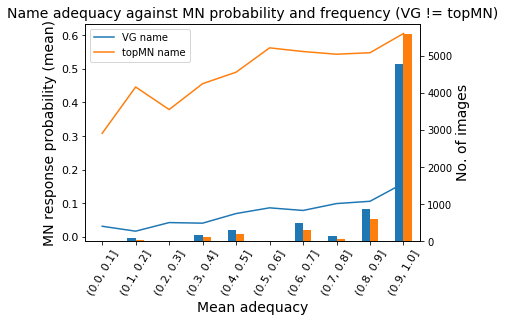

In [11]:
fig = plt.figure() 
ax = fig.add_subplot(111) 
ax2 = ax.twinx()

datastats_dfunc.plot(kind='line', 
                     ax=ax,
                     x="mean_adequacy", 
                     y=["VG name", "topMN name"], 
                     fontsize=11,
                     xticks=[0,1,2,3,4,5,6,7,8,9],
                     rot=60)
datastats_dfunc.plot(kind='bar', 
                     ax=ax2,
                     x="mean_adequacy", y=["VG name bin size", "topMN bin size"],
                    legend=None)

ax.set_ylabel('MN response probability (mean)', size=14)
ax.set_xlabel("Mean adequacy", size=14)
ax.set_title("Name adequacy against MN probability and frequency (VG != topMN)", size=14)
ax2.set_ylabel('No. of images', size=14)

plt.show()

Text(0, 0.5, 'MN response probability (mean)')

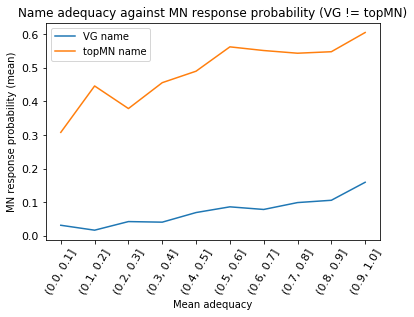

In [12]:
ax = datastats_dfunc.plot(kind='line', x="mean_adequacy", y=["VG name", "topMN name"], 
                     fontsize=11,
                     xticks=[0,1,2,3,4,5,6,7,8,9],
                     rot=60,
                     title="Name adequacy against MN response probability (VG != topMN)")
ax.set_xlabel("Mean adequacy")
ax.set_ylabel("MN response probability (mean)")